# HSV Operator Example

This example demonstrates the use of HSV operator which manipulates the hue, saturation and value (brighness) aspects of the image.


## Introduction
### HSV Color space
HSV represents colors by separating hue, saturation and brightness. In this color space, the hue is represented as an angle on the color circle. Saturation goes from 0 (greyscale) to 100% (fully saturated colors) and value goes from 0 (black) to 1 (full brightness). For details see:
[Wikipedia](https://en.wikipedia.org/wiki/HSL_and_HSV).

### A note on implementation
For performance reasons, DALI doesn't use the exact definition of HSV and approximates the operations in HSV space by linear (matrix) operations on RGB colors. This greatly improves performance at the cost of modest loss of fidelity.

## Step-by-step guide
1. Let's start from importing handful of utils and DALI itself.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
import matplotlib.pyplot as plt

batch_size = 10
image_filename = "../data/images"

Batch size is greater than one to facilitate switching between images at the end of the notebook.

2. Next, let's implement the pipelines. We've presented 2 versions of a pipeline. The CPU one does all the processing (i.e. reading file, decoding it and HSV manipulation) on the CPU, while the other pipeline conducts decoding and HSV manipulation on the GPU.

In [2]:
class HsvCpuPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(HsvCpuPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.hsv = ops.Hsv(device="cpu", hue=120, saturation=1, value=.4, dtype=types.UINT8)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        converted = self.hsv(image)
        return image, converted
    
class HsvGpuPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(HsvGpuPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        self.hsv = ops.Hsv(device="gpu", hue=+120, saturation=2, value=1, dtype=types.UINT8)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        converted = self.hsv(image.gpu())
        return image, converted

The function below is used to actually display result of HSV manipulation in DALI. Since the pipelines we set up return 2 outputs: modified image and original image, the function aquires both of them from the output and displays them. Additional flag (`cpu`) is specified, to determine, whether the pipeline output comes from CPU or GPU. In the latter case, we have to tell the output, to return a CPU-accessible copy of the data.

In [3]:
def display(output, cpu = True):
    i = 0  # Tweak that to have various images from batch
    img1 = output[0].at(i) if cpu else output[0].as_cpu().at(i)
    img2 = output[1].at(i) if cpu else output[1].as_cpu().at(i)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img1);
    ax[1].imshow(img2);

3. Now let's just build the pipelines, run them and display the results. First the GPU one:

In [4]:
pipegpu = HsvGpuPipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipegpu.build()          
gpu_output = pipegpu.run()

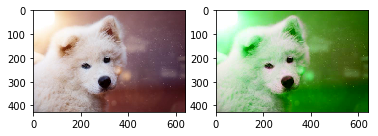

In [5]:
display(gpu_output, cpu=False)

4. And the CPU:

In [6]:
pipecpu = HsvCpuPipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipecpu.build()          
cpu_output = pipecpu.run()

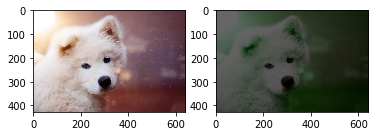

In [7]:
display(cpu_output)